# A5: Extension Plan
Patrick Peng (ID 202988)  
DATA 512, Autumn 2021

Assigned county: Milwaukee County, Wisconsin

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm

## Data acquisition and cleaning

### Traffic Accident Data

Traffic accident data comes from the [City of Milwaukee Open Data Portal](https://data.milwaukee.gov/dataset/trafficaccident).

Note that county-level data could not be found. The City of Milwaukee is the largest city in Milwaukee County, comprising about 60% of the county population.

In [3]:
# Read in the full dataset
df = pd.read_csv('../data/trafficaccident.csv')

In [4]:
df.columns

Index(['CASENUMBER', 'CASEDATE', 'ACCIDENTLOC'], dtype='object')

In [5]:
# drop unneeded columns
df.drop(['ACCIDENTLOC'],axis=1,inplace=True)

# drop the time from the CASEDATE column, we just want the date
df['date'] = pd.to_datetime(df['CASEDATE']).dt.date
df.drop(['CASEDATE'],axis=1,inplace=True)

# aggregate: get count of accidents by date
accidents = df.groupby('date').count()
accidents.rename(columns={'CASENUMBER':'accident_count'},inplace=True)
accidents.index = pd.to_datetime(accidents.index)

# take 7-day rolling average to smooth out day-to-day noise
accidents['accident_count_7d_avg'] = accidents['accident_count'].rolling(window=7).mean().round()

# filter data to Jan 2020 and later
accidents = accidents[accidents.index.year>=2020]

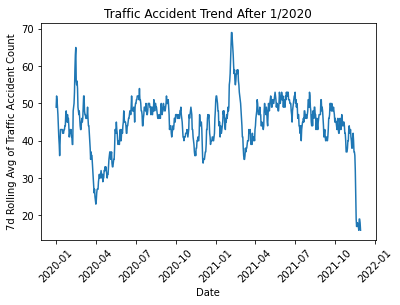

In [15]:
fig,ax = plt.subplots()
ax.plot(pd.to_datetime(accidents.index),accidents['accident_count_7d_avg'])
#accidents['accident_count_7d_avg'].plot()
ax.set_xlabel('Date')
ax.set_ylabel('7d Rolling Avg of Traffic Accident Count')
ax.set_title('Traffic Accident Trend After 1/2020')
plt.xticks(rotation=45)
plt.show()

### Traffic Volume from Wisconsin DOT Counter

The accident trend on its own doesn't mean much. A more useful measure is accidents per vehicle mile traveled (VMT), which normalizes the accident rate by the traffic volume. This allows us to distinguish whether the accident rate is due merely to increased traffic volume or some other factor. As sufficiently granular VMT data for Milwaukee could not be found, I will instead use the average daily traffic count at one of Wisconsin DOT's counters located on Interstate 94 west of Downtown Milwaukee as a rough proxy for regional traffic volumes, assuming it would follow the same overall trends. This data is aggregated at the monthly level and made available by the [Wisconsin Traffic Operations and Safety Laboratory](https://transportal.cee.wisc.edu/products/hourly-traffic-data/bysiteid/milwaukee.html) at the University of Wisconsin, Madison. Data is available for most months, excluding October 2020 for some reason.

Note: The file for November 2020 had no data for Sundays, so the report did not compute a 7-day average. I manually computed this value in the spreadsheet as an average of Mon-Sat, with Saturday double counted in the average as Saturday and Sunday volumes are typically similar.

In [18]:
# loop through the data/CT-400003 directory containing the monthly traffic count reports
# Collect the one cell containing the avg daily volume for that month
file_list = os.listdir('../data/CT-400003/')
date_list = []
count_list = []
for f in file_list:
    y = f[10:14]
    m = f[15:17]
    date_list.append(y+'-'+m+'-01')
    df_temp = pd.read_excel('../data/CT-400003/'+f,skiprows=9,engine='openpyxl')
    ct = df_temp['Unnamed: 32'][25]
    count_list.append(round(ct))

In [19]:
date_list = pd.to_datetime(date_list)
traffic_counts = pd.DataFrame(data=count_list,index=date_list,columns=['traffic_count'])

In [24]:
traffic_counts.sort_index(inplace=True)

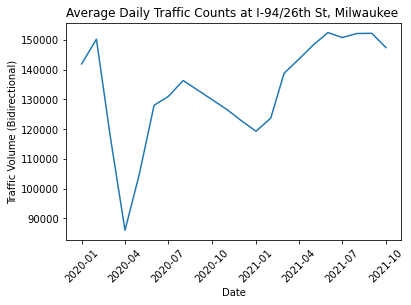

In [27]:
#traffic_counts.plot()
fig,ax = plt.subplots()
ax.plot(traffic_counts.index,traffic_counts['traffic_count'])
ax.set_xlabel('Date')
ax.set_ylabel('Traffic Volume (Bidirectional)')
ax.set_title('Average Daily Traffic Counts at I-94/26th St, Milwaukee ')
plt.xticks(rotation=45)
plt.show()

In [29]:
# average over the period 2020-Jan to 2021-Oct
traffic_counts['traffic_count'].mean()

133670.7142857143

### Calculation of Normalized Accident Rate

Now we'll compute our normalized accident rate. For interpretability, I will scale it by a factor of 100,000 (the average volume over the period of interest is about 133,000). The number itself is only useful as a relative measure, because it has the nonsensical units of 'accidents in Milwaukee per 100,000 vehicles on I-94 east of 26th Street' due to us not having access to a better measure of VMT. 

In [30]:
accidents['year-month'] = [str(i) + '-'+ str(j) for i, j in zip(accidents.index.year, accidents.index.month)]
traffic_counts['year-month'] = [str(i) + '-'+ str(j) for i, j in zip(traffic_counts.index.year, traffic_counts.index.month)]

In [31]:
df_joined = accidents.merge(traffic_counts,how='left',on='year-month')
df_joined.index = accidents.index
df_joined.dropna(axis=0,inplace=True)

In [32]:
df_joined['normalized_accident_rate'] = df_joined['accident_count_7d_avg']/df_joined['traffic_count']*100000

In [33]:
df_joined

,accident_count,accident_count_7d_avg,year-month,traffic_count,normalized_accident_rate
date,,,,,
2020-01-01,59,49.0,2020-1,141919.0,34.526737
2020-01-02,51,52.0,2020-1,141919.0,36.640619
2020-01-03,32,51.0,2020-1,141919.0,35.935992
2020-01-04,39,49.0,2020-1,141919.0,34.526737
2020-01-05,25,47.0,2020-1,141919.0,33.117483
...,...,...,...,...,...
2021-10-27,24,37.0,2021-10,147402.0,25.101423
2021-10-28,45,37.0,2021-10,147402.0,25.101423
2021-10-29,51,37.0,2021-10,147402.0,25.101423


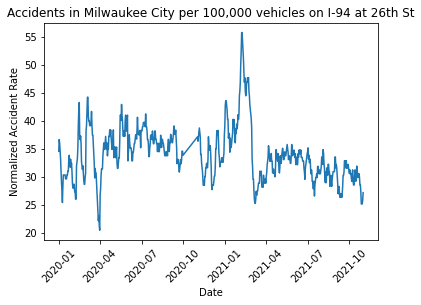

In [36]:
#df_joined['normalized_accident_rate'].plot()
fig,ax = plt.subplots()
ax.plot(df_joined.index,df_joined['normalized_accident_rate'])
ax.set_xlabel('Date')
ax.set_ylabel('Normalized Accident Rate')
ax.set_title('Accidents in Milwaukee City per 100,000 vehicles on I-94 at 26th St')
plt.xticks(rotation=45)
plt.show()

### COVID-19 Infections Data

Now for the COVID-19 infections dataset. We'll process it the same way as we did in A4 (see `a4-common-analysis.ipynb` for full description) to get the daily infection rate and the daily change in the infection rate.

In [38]:
# Read in the full dataset
case_data_full = pd.read_csv('../data/RAW_us_confirmed_cases.csv')

# Filter down to Milwaukee Co only, and melt from wide to long
case_data_mke = case_data_full[(case_data_full['Province_State']=='Wisconsin') & (case_data_full['Admin2']=='Milwaukee')]
case_data_mke = pd.melt(case_data_mke,id_vars=case_data_mke.columns[:11],var_name='Date',value_name='Total Cases')
case_data_mke['Date'] = pd.to_datetime(case_data_mke['Date'])

# Calculate daily new cases
case_data_mke['Daily New Cases'] = case_data_mke['Total Cases'].diff()

# Calculate 7-day moving average of daily new cases to smooth out day-to-day volatility
# h/t to Grant Savage for the suggestion on Slack
case_data_mke['Daily New Cases 7d Avg'] = case_data_mke['Daily New Cases'].rolling(window=7).mean().round()

# Per wikipedia, infection rate = (number of infections)/(number at risk of infection)
symptom_lag = 7
recovery_lag = 14

# Number of new infections (-7 day offset from Daily New Cases)
case_data_mke['New Infections'] = case_data_mke['Daily New Cases 7d Avg'].shift(periods=-1*symptom_lag)

# Cumulative new infections
case_data_mke['Cumulative Infections'] = case_data_mke['New Infections'].cumsum()

# Number of recoveries (+14 day offset from Daily New Cases)
case_data_mke['New Recoveries'] = case_data_mke['Daily New Cases 7d Avg'].shift(periods=recovery_lag)
case_data_mke['New Recoveries'] = case_data_mke['New Recoveries'].fillna(value=0)

# Cumulative recoveries
case_data_mke['Cumulative Recoveries'] = case_data_mke['New Recoveries'].cumsum()

# Active infections
case_data_mke['Active Infections'] = case_data_mke['Cumulative Infections'] - case_data_mke['Cumulative Recoveries']

# Calculate population at risk of infection (assume no reinfections can occur)
# Will use total population of Milwaukee Co minus the cumulative number of infections

mke_pop = 939489
case_data_mke['At Risk'] = mke_pop - case_data_mke['Cumulative Infections']

# Infection Rate
case_data_mke['Infection Rate'] = (case_data_mke['Active Infections']/case_data_mke['At Risk'])

# d(Infection Rate)/dT
case_data_mke['Change in Infection Rate'] = (case_data_mke['Infection Rate'].diff())#.rolling(window=7).mean()

case_data_mke.dropna(inplace=True)

case_data_mke2 = case_data_mke[['Date','Total Cases','Daily New Cases 7d Avg','Infection Rate','Change in Infection Rate']]
case_data_mke2.set_index('Date',drop=True,inplace=True)

In [39]:
case_data_mke2

,Total Cases,Daily New Cases 7d Avg,Infection Rate,Change in Infection Rate
Date,,,,
2020-01-29,0,0.0,0.000000,0.000000
2020-01-30,0,0.0,0.000000,0.000000
2020-01-31,0,0.0,0.000000,0.000000
2020-02-01,0,0.0,0.000000,0.000000
2020-02-02,0,0.0,0.000000,0.000000
...,...,...,...,...
2021-11-20,157736,344.0,0.008655,0.000150
2021-11-21,157736,344.0,0.008805,0.000150
2021-11-22,158453,339.0,0.008986,0.000181


## Analysis

We will join the Covid case dataframe `case_data_mke2` with the normalized accident rate dataframe `df_joined` on the date so that each date will have a `(infection rate, change in infection rate, normalized accident rate)` triple.

In [40]:
output_df = case_data_mke2.join(df_joined,how='inner')

In [41]:
output_df = output_df[['Infection Rate','Change in Infection Rate','normalized_accident_rate']]
output_df

,Infection Rate,Change in Infection Rate,normalized_accident_rate
2020-01-29,0.000000,0.000000,32.412855
2020-01-30,0.000000,0.000000,31.003601
2020-01-31,0.000000,0.000000,28.889719
2020-02-01,0.000000,0.000000,27.957505
2020-02-02,0.000000,0.000000,28.623159
...,...,...,...
2021-10-27,0.006536,-0.000129,25.101423
2021-10-28,0.006389,-0.000147,25.101423
2021-10-29,0.006369,-0.000020,25.101423
2021-10-30,0.006215,-0.000154,25.779840


In [42]:
inf_rate = output_df['Infection Rate'].to_numpy()
delta_inf_rate = output_df['Change in Infection Rate'].to_numpy()
accident_rate = output_df['normalized_accident_rate'].to_numpy()

We will perform an Ordinary Least Squares regression on `inf_rate` and `normalized_accident_rate`. We are testing the null hypothesis that these two parameters are uncorrelated.

In [50]:
model = sm.OLS(accident_rate, sm.add_constant(inf_rate))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.931
Date:                Mon, 13 Dec 2021   Prob (F-statistic):              0.165
Time:                        10:03:20   Log-Likelihood:                -1834.5
No. Observations:                 611   AIC:                             3673.
Df Residuals:                     609   BIC:                             3682.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.3997      0.279    123.263      0.0

The fit finds a very small negative correlation between infection rate and normalized accident rate - that is, higher infection rates are correlated with a small decrease in the normalized accident rate. 

Interpreting the coefficient: If two separate days have infection rates that differ by 1 percentage point (which is a lot - that's about 10,000 people, based on Milwaukee County pop ~ 1M) the day with the higher infection rate will see about 0.5 fewer car accidents in Milwaukee City per 100,000 vehicles counted on I-94.

However, this result is not statistically significant (p>0.05) and we are unable to reject the null hypothesis that infection rate and normalized accident rate are uncorrelated.

In [51]:
pred_vals = results.predict()
sort_ind = np.argsort(inf_rate)

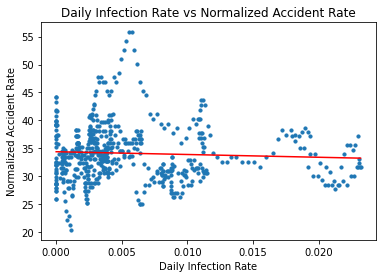

In [52]:
fig,ax=plt.subplots()
ax.scatter(inf_rate,accident_rate,s=10)
ax.plot(inf_rate[sort_ind],pred_vals[sort_ind],'r')
ax.set_xlabel('Daily Infection Rate')
ax.set_ylabel('Normalized Accident Rate')
ax.set_title('Daily Infection Rate vs Normalized Accident Rate')
plt.show()

Now we will perform an OLS regression on `delta_inf_rate` and `normalized_accident_rate`

In [53]:
model = sm.OLS(accident_rate, sm.add_constant(delta_inf_rate))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     27.26
Date:                Mon, 13 Dec 2021   Prob (F-statistic):           2.44e-07
Time:                        10:03:58   Log-Likelihood:                -1822.1
No. Observations:                 611   AIC:                             3648.
Df Residuals:                     609   BIC:                             3657.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.0589      0.194    175.679      0.0

The fit finds a small negative correlation between the rate of change of daily infection rate and normalized accident rate - that is, an increase in the infection rate is correlated with a small decrease in the normalized accident rate. 

Interpreting the coefficient: A day to day increase in the infection rate of 0.01 percentage points (~100 new cases, based on Milwaukee County pop ~ 1M) is associated with 0.7 fewer car accidents in Milwaukee City per 100,000 cars on I-94.

This result is statistically significant (p<0.05) and we are able to reject the null hypothesis that the change in infection rate is uncorrelated with normalized accident rate.

In [54]:
pred_vals = results.predict()
sort_ind = np.argsort(delta_inf_rate)

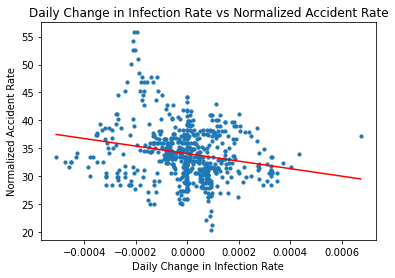

In [55]:
fig,ax=plt.subplots()
ax.scatter(delta_inf_rate,accident_rate,s=10)
ax.plot(delta_inf_rate[sort_ind],pred_vals[sort_ind],'r')
ax.set_xlabel('Daily Change in Infection Rate')
ax.set_ylabel('Normalized Accident Rate')
ax.set_title('Daily Change in Infection Rate vs Normalized Accident Rate')
plt.show()